In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive

/content/drive/My Drive


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#!pip3 install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!#pip install typeguard

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.torch_core import *
from fastai.torch_core import Module
import torch
import torchvision
import torch.nn as nn
import random
bs = 32
random.seed(42)

In [ ]:
%cd orig

/content/drive/My Drive/orig


In [ ]:
#!unzip 'data-orig.zip'

In [ ]:
path_img = Path('data')## Loading data 
#data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs), check_ext=False)## Normalizing data based on Image net parameters
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


ImageDataBunch;

Train: LabelList (1180 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: data;

Valid: LabelList (398 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: data;

Test: None

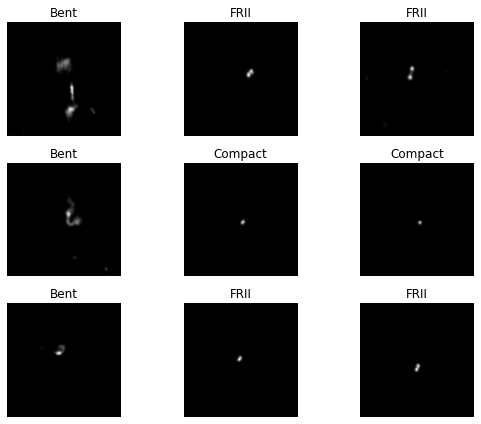

In [ ]:
data.show_batch(rows=3, figsize=(8,6))

In [ ]:
from fastai.callbacks import *

In [ ]:
from fastai.callback import *

In [ ]:
def FlatCosAnnealScheduler(self:Learner, lr:float=4e-3, tot_epochs:int=1, start_pct:float=0.72,
                           curve='cosine'):
    n = len(self.dls.train)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":        curve_sched=SchedCos(lr, 0)
    elif curve=="linear":      curve_sched=SchedLin(lr, 0)
    elif curve=="exponential": curve_sched=SchedExp(lr, 0)
    else: raiseValueError(f"annealing type not supported {curve}")
    scheds = [SchedNo(lr, start_pct), curve_sched]
    scheds = {'lr': combine_scheds([start_pct, 1-start_pct], scheds)}
    return scheds


In [ ]:
learn = cnn_learner(data, models.densenet161, opt_func=torch.optim.SGD, metrics=accuracy)
#sched = {'lr': callbacks.general_sched.annealing_linear(1e-4, 1e-25)}
#sched = {'lr': SchedLin(1e-4, 1e-25)}
learn.freeze()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


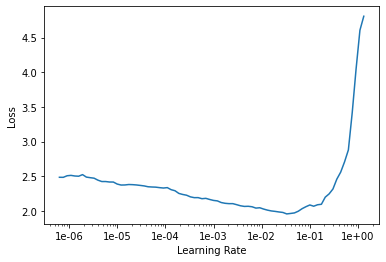

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.basic_train import *
from fastai.vision.learner import *
from fastai.callbacks import GeneralScheduler

In [ ]:
#seed 42
lr_steep = 1e-4
callback = FlatCosAnnealScheduler(learn, lr_steep, start_pct=.72, tot_epochs=20)
learn.fit(20, lr_steep, callbacks=callback)

epoch,train_loss,valid_loss,accuracy,time
0,1.648974,1.495642,0.359296,01:19
1,1.487436,1.169664,0.557789,00:23
2,1.332225,0.996326,0.635678,00:22
3,1.241431,0.900095,0.698492,00:22
4,1.161592,0.856724,0.683417,00:22
5,1.081971,0.718452,0.726131,00:22
6,1.029896,0.820355,0.721106,00:22
7,0.923525,0.650912,0.751256,00:22
8,0.860303,0.567939,0.781407,00:22
9,0.817812,0.619417,0.763819,00:22


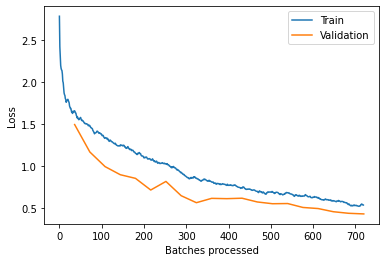

In [ ]:
#CosineAnneal losses
learn.recorder.plot_losses()

In [ ]:
learn = cnn_learner(data, models.densenet161, opt_func=torch.optim.SGD, metrics=accuracy)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


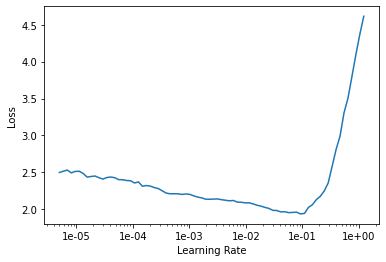

In [ ]:
learn.lr_find(start_lr=1e-6, end_lr=1e1, wd=5e-3)
learn.recorder.plot()

In [ ]:
# def f_sched(*args):
#     lr = 2e-3
#     lrs = [lr/2., lr/2.,lr/2.,lr]
#     return [combine_scheds([0.2,0.8], [SchedCos(lr/10.,lr), SchedCos(lr,lr/1e5)])(*args) for lr in lrs]

# sched = {'lr': f_sched}

# #learner.fit(1, cbs=ParamScheduler(sched))
# #sched = {'lr': SchedLin(1e-4, 1e-3)}
# #learn.fit(1, )
# #learn.fit(1, cbs=torch.optim.lr_scheduler.MultiStepLR)
# learn.fit(1, lr=slice(1e-4,1e-2), callbacks=ParamScheduler(f_sched))
# learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,2.211546,2.047849,0.512563,00:22


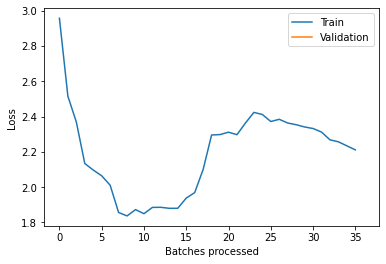

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(2e-3,4e-2))
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


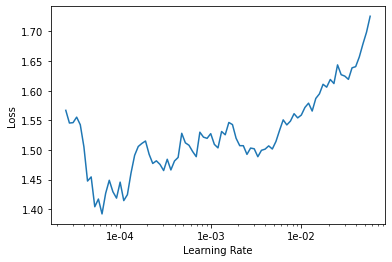

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.611607,1.349052,0.673367,00:30
1,1.537861,1.351392,0.698492,00:30
2,1.535988,1.363751,0.695980,00:29


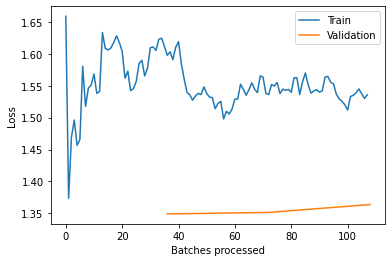

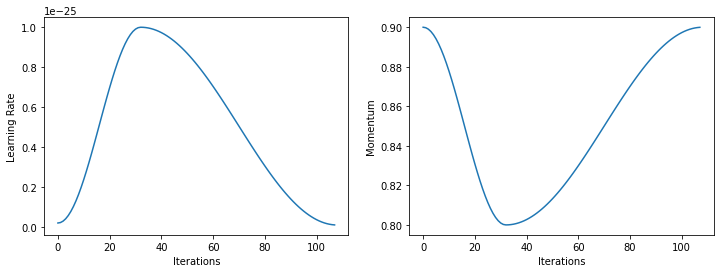

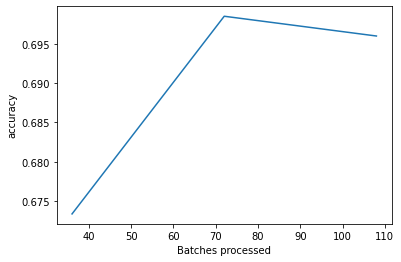

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-38, 1e-25), div_factor=50, final_div=100, wd=1e-4, moms=(0.9, 0.8))
learn.recorder.plot_losses()
# schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,1.283234,3.711963,0.525126,00:30
1,1.150292,0.907414,0.716080,00:30
2,0.970986,2.834347,0.334171,00:29
3,0.803577,0.533209,0.824121,00:29
4,0.645913,0.780473,0.773869,00:29
5,0.603412,0.509718,0.831658,00:29
6,0.523315,0.403265,0.869347,00:29
7,0.455979,0.385894,0.884422,00:29
8,0.413012,0.367102,0.891960,00:29
9,0.350267,0.329816,0.912060,00:29


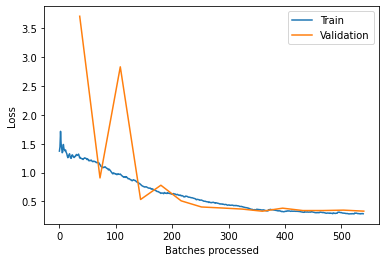

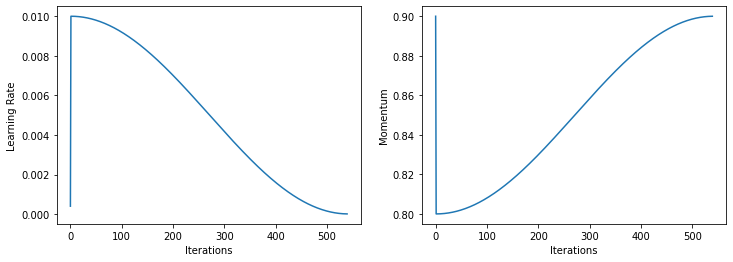

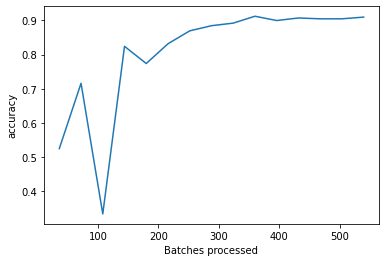

In [ ]:
learn.fit_one_cycle(cyc_len=15, max_lr=slice(1e-4, 1e-2), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0
#learn.save('stage-3')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [ ]:
################ MULTISTEP LR ######################

In [ ]:
schedmslr = [torch.optim.lr_scheduler.MultiStepLR]

In [ ]:
learnmslr = cnn_learner(data, models.densenet161, opt_func=torch.optim.SGD, metrics=accuracy)
learnmslr.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


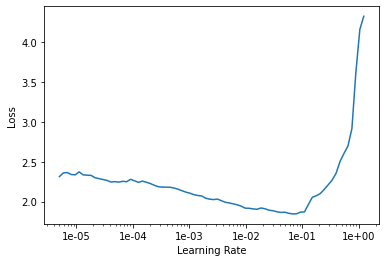

In [ ]:
learnmslr.lr_find(start_lr=1e-6, end_lr=1e1, wd=5e-3)
learnmslr.recorder.plot()

In [ ]:
lr_steep = 1e-38
learn.fit(20, lr_steep, callbacks=schedmslr)

In [ ]:
learn.save('rg-sgd-seed1234-25June')

In [ ]:
learn.load('rg-adam-seed1234-25June')
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(8,8))

In [ ]:
losses, indexes = interp.top_losses(30)

top_loss_paths = data.valid_ds.x.items[indexes]

print(top_loss_paths)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
path_img = Path('data')## Loading data 
#data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs), check_ext=False)## Normalizing data based on Image net parameters
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='test', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.densenet161, opt_func=torch.optim.Adam, metrics=accuracy)

In [ ]:
learn = learn.load('rg-adam-seed1234-25June')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(8,8))

In [ ]:
losses, indexes = interp.top_losses(36)

top_loss_paths = data.valid_ds.x.items[indexes]

print(top_loss_paths)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
import glob

image_list = glob.glob('data/test/*/*')

Bent = 0
Pred_Bent=0
Compact=0
Pred_Compact=0
FRI=0
Pred_FRI=0
FRII=0
Pred_FRII = 0 

for each in image_list:
    img = open_image(each)
    each = each.split('/')
    rg_class = each[2]
    pred_class, pred_idx, outputs = learn.predict(img)
    pred_class = str(pred_class)
         
    if rg_class == 'Bent':
        Bent += 1
        if pred_class == 'Bent':
            Pred_Bent += 1
            print(each[2:], pred_class)
        # else:
        #     print(each[2:], pred_class)
    elif rg_class == 'Compact':
        Compact += 1
        if pred_class == 'Compact':
            Pred_Compact += 1
            print(each[2:], pred_class)
        # else:
        #    print(each[2:], pred_class)
    elif rg_class == 'FRI':
        FRI += 1
        if pred_class == 'FRI':
            Pred_FRI += 1
            print(each[2:], pred_class)
        # else:
        #     print(each[2:], pred_class)
    elif rg_class == 'FRII':
        FRII += 1
        if pred_class == 'FRII':
            Pred_FRII += 1
            print(each[2:], pred_class)
        # else:
        #    print(each[2:], pred_class)

In [ ]:
print('TP Bent: ' + str(Pred_Bent) + '/' + str(Bent))
print('TP Compact: ' + str(Pred_Compact) + '/' + str(Compact))
print('TP FRI: ' + str(Pred_FRI) + '/' + str(FRI) )
print('TP FRII: ' + str(Pred_FRII) + '/' + str(FRII) )